In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import pandas as pd

Using device: cpu


  4%|█▎                                 | 1160/30000 [00:00<00:02, 11594.65it/s]

[0] m_t: mean=0.6147, min=0.3685, max=0.9842
[0] grad norm: 0.820146
Step     0 | θ = [ 0.00040034 -0.00071354] | error = 2.2353
Step  1000 | θ = [ 0.31269506 -0.62903917] | error = 1.5336
Step  2000 | θ = [ 0.5276588 -1.0582535] | error = 1.0536


 17%|█████▉                             | 5130/30000 [00:00<00:01, 12969.09it/s]

Step  3000 | θ = [ 0.6744025 -1.3510602] | error = 0.7260
Step  4000 | θ = [ 0.7747508 -1.5534433] | error = 0.5002
Step  5000 | θ = [ 0.84619737 -1.6936024 ] | error = 0.3428


 26%|█████████                          | 7799/30000 [00:00<00:01, 13158.02it/s]

Step  6000 | θ = [ 0.89462316 -1.7935207 ] | error = 0.2318
Step  7000 | θ = [ 0.9291785 -1.8587259] | error = 0.1580
Step  8000 | θ = [ 0.9511797 -1.9034563] | error = 0.1082


 35%|███████████▉                      | 10503/30000 [00:00<00:01, 13364.63it/s]

Step  9000 | θ = [ 0.96833247 -1.9318663 ] | error = 0.0751
[10000] m_t: mean=0.6327, min=0.3679, max=0.9947
[10000] grad norm: 0.032576
Step 10000 | θ = [ 0.9774883 -1.9540077] | error = 0.0512
Step 11000 | θ = [ 0.9838486 -1.9701965] | error = 0.0339


 44%|██████████████▉                   | 13232/30000 [00:01<00:01, 11689.52it/s]

Step 12000 | θ = [ 0.98860264 -1.9786996 ] | error = 0.0242
Step 13000 | θ = [ 0.9919188 -1.985809 ] | error = 0.0163
Step 14000 | θ = [ 0.99336016 -1.991348  ] | error = 0.0109


 58%|███████████████████▌              | 17264/30000 [00:01<00:00, 12789.95it/s]

Step 15000 | θ = [ 0.99647856 -1.9919744 ] | error = 0.0088
Step 16000 | θ = [ 0.99762994 -1.9931184 ] | error = 0.0073
Step 17000 | θ = [ 0.9971961 -1.9963832] | error = 0.0046


 66%|██████████████████████▌           | 19925/30000 [00:01<00:00, 13072.32it/s]

Step 18000 | θ = [ 0.9984639 -1.9958676] | error = 0.0044
Step 19000 | θ = [ 1.0021169 -1.9979482] | error = 0.0029
[20000] m_t: mean=0.6574, min=0.3684, max=0.9881
[20000] grad norm: 0.046134
Step 20000 | θ = [ 1.001369  -1.9978672] | error = 0.0025


 76%|█████████████████████████▋        | 22669/30000 [00:01<00:00, 13392.40it/s]

Step 21000 | θ = [ 1.0007851 -1.9988928] | error = 0.0014
Step 22000 | θ = [ 0.9996086 -1.9978322] | error = 0.0022
Step 23000 | θ = [ 0.9996402 -1.9979216] | error = 0.0021


 85%|████████████████████████████▊     | 25473/30000 [00:01<00:00, 13696.30it/s]

Step 24000 | θ = [ 1.0001198 -1.9993484] | error = 0.0007
Step 25000 | θ = [ 0.99887735 -1.9985884 ] | error = 0.0018
Step 26000 | θ = [ 0.99889076 -1.998863  ] | error = 0.0016


 99%|█████████████████████████████████▌| 29580/30000 [00:02<00:00, 13548.98it/s]

Step 27000 | θ = [ 0.99902034 -2.0002666 ] | error = 0.0010
Step 28000 | θ = [ 0.99781877 -2.0003178 ] | error = 0.0022
Step 29000 | θ = [ 0.9978682 -1.9992123] | error = 0.0023


100%|██████████████████████████████████| 30000/30000 [00:02<00:00, 13094.75it/s]


Final θ estimate (avg over last 100): [ 0.99916357 -1.9979808 ]
True μ = [ 1. -2.]


Text(0.5, 1.0, 'Trajectory of θ')

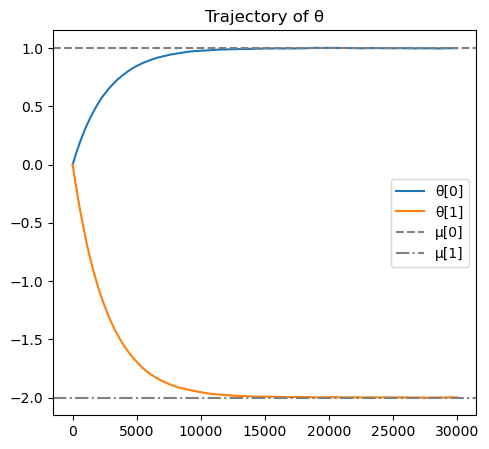

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dim = 2
mu_true = torch.tensor([1.0, -2.0], device=device)
beta = 10**8
initial_lr = 1e-3
total_steps = 30000
avg_window = 100

def simulate_xt(x0, t):
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    z = torch.randn_like(x0)
    xt = m_t[:, None] * x0 + sigma_t[:, None] * z
    return xt, z, m_t, sigma_t

def sgld_step(theta, step, batch, beta):
    tau, x0, z = batch
    m_t = torch.exp(-tau)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * tau))
    if step % 10000 == 0:
        print(f"[{step}] m_t: mean={m_t.mean():.4f}, min={m_t.min():.4f}, max={m_t.max():.4f}")

    sigma_inv = 1.0 / sigma_t[:, None]

    grad_terms = sigma_inv * z - m_t[:, None] * x0 - sigma_t[:, None] * z + m_t[:, None] * theta
    coeff = 2 * m_t * sigma_t**2
    grad = coeff[:, None] * grad_terms
    grad = grad.mean(dim=0)

    lr = initial_lr

    noise = torch.randn_like(theta)
    theta_next = theta - lr * grad + torch.sqrt(torch.tensor(2 * lr / beta, device=theta.device)) * noise
    if step % 10000 == 0:
        print(f"[{step}] grad norm: {grad.norm().item():.6f}")

    return theta_next

def get_data_loader(mu, batch_size=128, dim=2):
    while True:
        yield torch.randn(batch_size, dim, device=device) + mu


theta = torch.zeros(dim, device=device)
theta_history = []
error_history = []
data = get_data_loader(mu=mu_true, batch_size=128, dim=dim)

for step in tqdm(range(total_steps)):
    tau = torch.rand(128, device=device) * (1.0 - 1e-3) + 1e-3 
    x0 = next(data)
    _, z, _, _ = simulate_xt(x0, tau)
    batch = (tau, x0, z)

    theta = sgld_step(theta, step, batch, beta)

    err = torch.norm(theta - mu_true).item()

    theta_history.append(theta.detach().cpu().numpy())
    error_history.append(err)

    if step % 1000 == 0:
        print(f"Step {step:5d} | θ = {theta.cpu().numpy()} | error = {err:.4f}")

theta_np = np.array(theta_history)
theta_avg = np.mean(theta_np[-avg_window:], axis=0)

print(f"\nFinal θ estimate (avg over last {avg_window}): {theta_avg}")
print(f"True μ = {mu_true.cpu().numpy()}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta_np[:, 0], label='θ[0]')
plt.plot(theta_np[:, 1], label='θ[1]')
plt.axhline(mu_true[0].item(), color='grey', linestyle='--', label='μ[0]')
plt.axhline(mu_true[1].item(), color='grey', linestyle='-.', label='μ[1]')
plt.legend()
plt.title("Trajectory of θ")



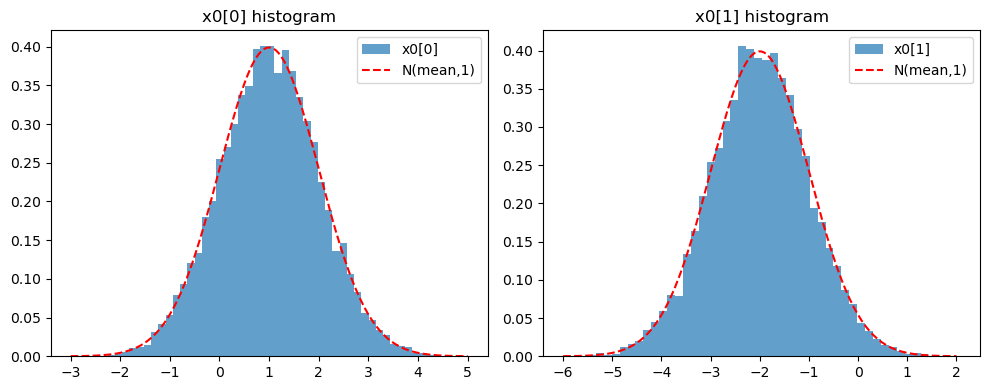

In [10]:
big_batch = next(get_data_loader(mu=mu_true, batch_size=10000, dim=dim))

plt.figure(figsize=(10,4))

for i in range(dim):
    plt.subplot(1, dim, i+1)
    plt.hist(big_batch[:,i].cpu().numpy(), bins=50, density=True, alpha=0.7, label=f"x0[{i}]")
    
    from scipy.stats import norm
    x_vals = np.linspace(mu_true[i].item()-4, mu_true[i].item()+4, 200)
    plt.plot(x_vals, norm.pdf(x_vals, loc=mu_true[i].item(), scale=1.0), 'r--', label="N(mean,1)")
    
    plt.title(f"x0[{i}] histogram")
    plt.legend()

plt.tight_layout()
plt.show()


Using device: cpu


  4%|█▌                                 | 1324/30000 [00:00<00:02, 13236.04it/s]

[0] grad norm: 0.573017 | theta: [0. 0.]
Step     0 | θ = [ 0.00027966 -0.00050748] | error = 2.2355
Step  1000 | θ = [ 0.21245284 -0.42240223] | error = 1.7632
Step  2000 | θ = [ 0.3785542  -0.75562024] | error = 1.3909


 18%|██████▍                            | 5503/30000 [00:00<00:01, 13854.81it/s]

Step  3000 | θ = [ 0.5104878 -1.0178396] | error = 1.0974
Step  4000 | θ = [ 0.6136961 -1.2231619] | error = 0.8676
[5000] grad norm: 0.211318 | theta: [ 0.69188565 -1.3879082 ]
Step  5000 | θ = [ 0.69200164 -1.3880918 ] | error = 0.6851


 28%|█████████▋                         | 8291/30000 [00:00<00:01, 13821.76it/s]

Step  6000 | θ = [ 0.7572442 -1.5160704] | error = 0.5414
Step  7000 | θ = [ 0.8085738 -1.6181574] | error = 0.4271
Step  8000 | θ = [ 0.8486376 -1.6976762] | error = 0.3381


 37%|████████████▌                     | 11058/30000 [00:00<00:01, 13798.10it/s]

Step  9000 | θ = [ 0.88041914 -1.7622238 ] | error = 0.2662
[10000] grad norm: 0.057513 | theta: [ 0.9059585 -1.8120382]
Step 10000 | θ = [ 0.9059786 -1.8120906] | error = 0.2101
Step 11000 | θ = [ 0.9253767 -1.850271 ] | error = 0.1673


 46%|███████████████▋                  | 13876/30000 [00:01<00:01, 13943.59it/s]

Step 12000 | θ = [ 0.9397709 -1.8818872] | error = 0.1326
Step 13000 | θ = [ 0.9521972 -1.907489 ] | error = 0.1041
Step 14000 | θ = [ 0.961968  -1.9266396] | error = 0.0826


 55%|██████████████████▊               | 16648/30000 [00:01<00:00, 13697.80it/s]

[15000] grad norm: 0.034200 | theta: [ 0.96878004 -1.9429467 ]
Step 15000 | θ = [ 0.9687999 -1.9429154] | error = 0.0651
Step 16000 | θ = [ 0.9747005 -1.9541949] | error = 0.0523
Step 17000 | θ = [ 0.9809909 -1.9638263] | error = 0.0409


 65%|██████████████████████            | 19430/30000 [00:01<00:00, 13811.94it/s]

Step 18000 | θ = [ 0.9852281 -1.9730856] | error = 0.0307
Step 19000 | θ = [ 0.9885401 -1.9805515] | error = 0.0226
[20000] grad norm: 0.044778 | theta: [ 0.9911893 -1.9845772]
Step 20000 | θ = [ 0.9911598 -1.9846079] | error = 0.0178


 79%|██████████████████████████▋       | 23584/30000 [00:01<00:00, 13799.56it/s]

Step 21000 | θ = [ 0.9933539 -1.988056 ] | error = 0.0137
Step 22000 | θ = [ 0.9950747 -1.992306 ] | error = 0.0091
Step 23000 | θ = [ 0.9943845 -1.9943758] | error = 0.0079


 88%|█████████████████████████████▊    | 26350/30000 [00:01<00:00, 13648.74it/s]

Step 24000 | θ = [ 0.9937367 -1.9974725] | error = 0.0068
[25000] grad norm: 0.014395 | theta: [ 0.9950526 -1.9974419]
Step 25000 | θ = [ 0.99506676 -1.9974514 ] | error = 0.0056
Step 26000 | θ = [ 0.99520636 -1.997978  ] | error = 0.0052


 97%|████████████████████████████████▉ | 29075/30000 [00:02<00:00, 13530.77it/s]

Step 27000 | θ = [ 0.99764484 -1.9990412 ] | error = 0.0025
Step 28000 | θ = [ 0.99807376 -2.0010207 ] | error = 0.0022
Step 29000 | θ = [ 1.00028   -2.0016162] | error = 0.0016


100%|██████████████████████████████████| 30000/30000 [00:02<00:00, 13702.05it/s]



Final θ estimate (avg over last 100): [ 0.99922156 -1.9996582 ]
True μ = [ 1. -2.]


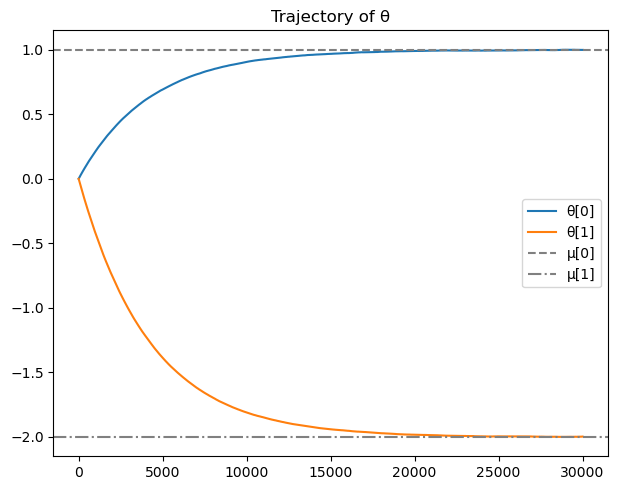

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dim = 2
mu_true = torch.tensor([1.0, -2.0], device=device)
beta = 1e8
initial_lr = 1e-3
total_steps = 30000
avg_window = 100

def simulate_xt(x0, t):
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    z = torch.randn_like(x0)
    xt = m_t[:, None] * x0 + sigma_t[:, None] * z
    return xt, z, m_t, sigma_t

def sgld_step(theta, step, batch, beta):
    tau, x0, z = batch

    m_t = torch.exp(-tau)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * tau))

    x_t = m_t[:, None] * x0 + sigma_t[:, None] * z

    s_val = - x_t + m_t[:, None] * theta
    grad_s = m_t[:, None]
    term = (z / sigma_t[:, None]) + s_val
    H = 2 * m_t * sigma_t**2
    grad = (H[:, None] * term * grad_s).mean(dim=0)

    lr = initial_lr
    noise = torch.randn_like(theta)
    theta_next = theta - lr * grad + torch.sqrt(torch.tensor(2 * lr / beta, device=theta.device)) * noise

    if step % 5000 == 0:
        print(f"[{step}] grad norm: {grad.norm().item():.6f} | theta: {theta.cpu().numpy()}")

    return theta_next

def get_data_loader(mu, batch_size=128, dim=2):
    while True:
        yield torch.randn(batch_size, dim, device=device) + mu

theta = torch.zeros(dim, device=device)
theta_history = []
error_history = []
data = get_data_loader(mu=mu_true, batch_size=128, dim=dim)

for step in tqdm(range(total_steps)):
    tau = torch.rand(128, device=device) * (1.0 - 1e-3) + 1e-3 
    x0 = next(data)
    _, z, _, _ = simulate_xt(x0, tau)
    batch = (tau, x0, z)

    theta = sgld_step(theta, step, batch, beta)

    err = torch.norm(theta - mu_true).item()

    theta_history.append(theta.detach().cpu().numpy())
    error_history.append(err)

    if step % 1000 == 0:
        print(f"Step {step:5d} | θ = {theta.cpu().numpy()} | error = {err:.4f}")

theta_np = np.array(theta_history)
theta_avg = np.mean(theta_np[-avg_window:], axis=0)

print(f"\nFinal θ estimate (avg over last {avg_window}): {theta_avg}")
print(f"True μ = {mu_true.cpu().numpy()}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(theta_np[:, 0], label='θ[0]')
plt.plot(theta_np[:, 1], label='θ[1]')
plt.axhline(mu_true[0].item(), color='grey', linestyle='--', label='μ[0]')
plt.axhline(mu_true[1].item(), color='grey', linestyle='-.', label='μ[1]')
plt.legend()
plt.title("Trajectory of θ")

plt.tight_layout()
plt.show()

Using device: cpu


100%|███████████████████████████████████████| 300/300 [00:00<00:00, 2585.54it/s]

Step     0 | loss = 1.926455 | theta_pred mean = [ 0.13769457 -0.24163848]

Final theta estimate (avg over last 1): [ 1.0104795 -2.017815 ]
True mu = [ 1. -2.]


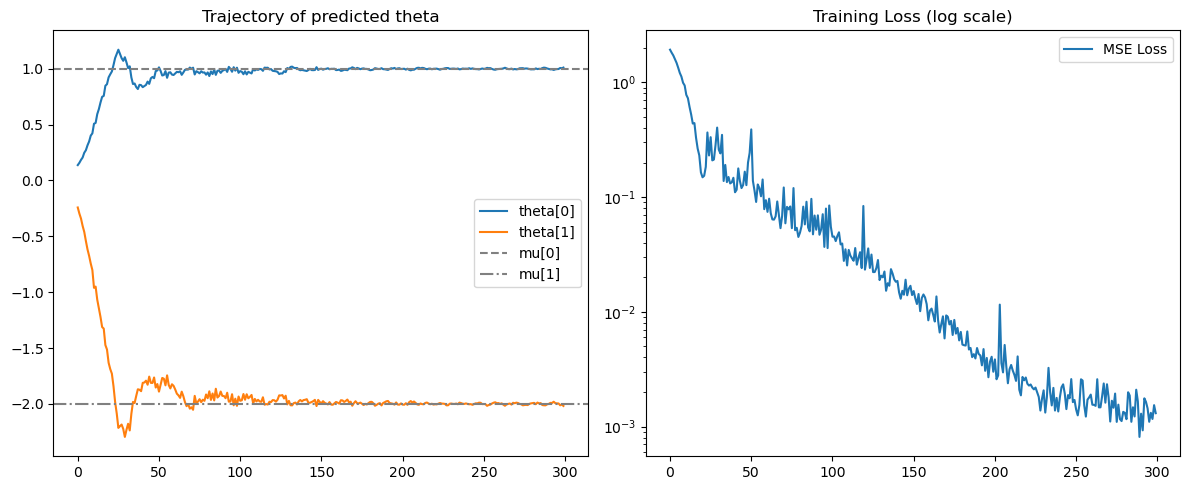

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dim = 2
mu_true = torch.tensor([1.0, -2.0], device=device)
total_steps = 300
avg_window = 1
batch_size = 128
beta = 1e8

def simulate_xt(x0, t):
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    z = torch.randn_like(x0)
    xt = m_t[:, None] * x0 + sigma_t[:, None] * z
    return xt, z, m_t, sigma_t

def get_data_loader(mu, batch_size=128, dim=2):
    while True:
        yield torch.randn(batch_size, dim, device=device) + mu

class ThetaPredictor(nn.Module):
    def __init__(self, input_dim=11, hidden_dim=64, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model = ThetaPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

data = get_data_loader(mu=mu_true, batch_size=batch_size, dim=dim)

theta_history = []
loss_history = []
score_history = []
true_score_history = []

for step in tqdm(range(total_steps)):
    tau = torch.rand(batch_size, device=device) * (1.0 - 1e-3) + 1e-3
    x0 = next(data)
    x_t, z, m_t, sigma_t = simulate_xt(x0, tau)

    with torch.no_grad():
        theta_guess = torch.zeros(dim, device=device)
        s_val = -x_t + m_t[:, None] * theta_guess
        term = (z / sigma_t[:, None]) + s_val

    features = torch.cat([
        tau[:, None],           
        m_t[:, None],           
        sigma_t[:, None],       
        x0,                     
        z,                      
        x_t,                    
        term                    
    ], dim=1)  

    theta_pred = model(features)

    target = mu_true.expand_as(theta_pred)
    loss = ((theta_pred - target) ** 2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    theta_mean = theta_pred.mean(dim=0).detach().cpu().numpy()
    theta_history.append(theta_mean.copy())
    s_pred = -x_t + m_t[:, None] * theta_pred
    score_history.append(s_pred.detach().cpu().numpy())
    s_true = -x_t + m_t[:, None] * mu_true
    s_true_mean = s_true.mean(dim=0).cpu().numpy()
    true_score_history.append(s_true_mean.copy())


    loss_history.append(loss.item())

    if step % 1000 == 0:
        print(f"Step {step:5d} | loss = {loss.item():.6f} | theta_pred mean = {theta_pred.mean(dim=0).detach().cpu().numpy()}")


theta_np = np.array(theta_history)
theta_avg = np.mean(theta_np[-avg_window:], axis=0)

print(f"\nFinal theta estimate (avg over last {avg_window}): {theta_avg}")
print(f"True mu = {mu_true.cpu().numpy()}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(theta_np[:, 0], label='theta[0]')
plt.plot(theta_np[:, 1], label='theta[1]')
plt.axhline(mu_true[0].item(), color='grey', linestyle='--', label='mu[0]')
plt.axhline(mu_true[1].item(), color='grey', linestyle='-.', label='mu[1]')
plt.legend()
plt.title("Trajectory of predicted theta")

plt.subplot(1, 2, 2)
plt.plot(loss_history, label='MSE Loss')
plt.yscale('log')
plt.legend()
plt.title("Training Loss (log scale)")

plt.tight_layout()
plt.show()


In [16]:
with torch.no_grad():
    tau = torch.rand(batch_size, device=device) * (1.0 - 1e-3) + 1e-3
    x0 = next(data)
    x_t, z, m_t, sigma_t = simulate_xt(x0, tau)

    s_val = -x_t + m_t[:, None] * torch.zeros(dim, device=device)  # init theta=0
    term = (z / sigma_t[:, None]) + s_val
    features = torch.cat([
        tau[:, None],
        m_t[:, None],
        sigma_t[:, None],
        x0,
        z,
        x_t,
        term
    ], dim=1)

    theta_pred = model(features)

    s_pred = -x_t + m_t[:, None] * theta_pred

print(f"\nSample score estimate s_pred[0]: {s_pred[0].cpu().numpy()}")


Sample score estimate s_pred[0]: [ 0.4141373 -1.7085086]


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 6789.18it/s]


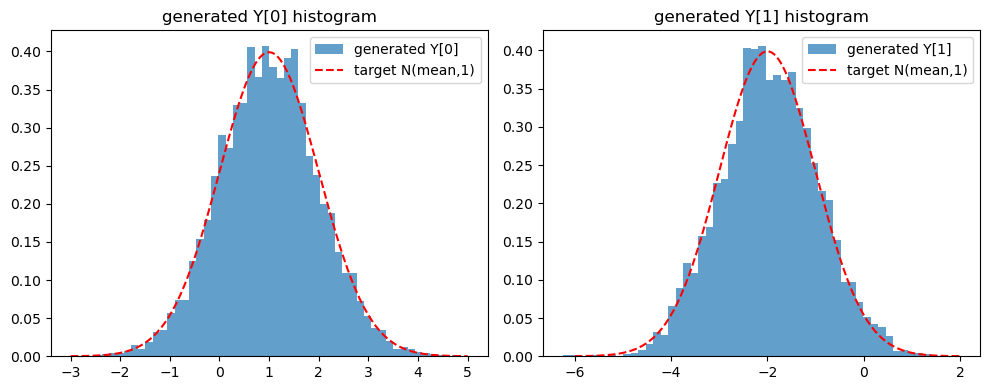

In [17]:
N_samples = 5000
gamma = 1e-3
K = 2000
T = 2.0
timesteps = np.linspace(0, T, K+1)

Y0_batch = torch.randn(N_samples, dim, device=device)

Y_all = Y0_batch.clone()

theta_hat = theta.clone().detach()

for k in tqdm(range(K)):
    t_k = timesteps[k]
    tau = torch.tensor([T - t_k], device=device)

    m_t = torch.exp(-tau)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * tau))

    s_val = - Y_all + m_t * theta_hat

    drift = Y_all + 2 * s_val
    noise = torch.randn_like(Y_all)

    Y_all = Y_all + gamma * drift + torch.sqrt(torch.tensor(2*gamma)) * noise

samples = Y_all.detach().cpu().numpy()

plt.figure(figsize=(10,4))
for i in range(dim):
    plt.subplot(1, dim, i+1)
    plt.hist(samples[:,i], bins=50, density=True, alpha=0.7, label=f"generated Y[{i}]")

    from scipy.stats import norm
    x_vals = np.linspace(mu_true[i].item()-4, mu_true[i].item()+4, 200)
    plt.plot(x_vals, norm.pdf(x_vals, loc=mu_true[i].item(), scale=1.0), 'r--', label="target N(mean,1)")

    plt.title(f"generated Y[{i}] histogram")
    plt.legend()

plt.tight_layout()
plt.show()


Using device: cpu


  3%|▉                                    | 776/30000 [00:00<00:03, 7755.59it/s]

[0] grad norm: 0.533585 | theta: [0. 0.]
Step     0 | θ = [ 0.00025509 -0.00046873] | error = 2.2355 | loss = 1.1099
Step  1000 | θ = [ 0.21235989 -0.42088333] | error = 1.7646 | loss = 0.6598


 11%|███▉                                | 3277/30000 [00:00<00:03, 8175.58it/s]

Step  2000 | θ = [ 0.3768955 -0.7538045] | error = 1.3933 | loss = 0.4222
Step  3000 | θ = [ 0.50872904 -1.0165285 ] | error = 1.0993 | loss = 0.2520


 17%|█████▉                              | 4953/30000 [00:00<00:03, 7256.36it/s]

Step  4000 | θ = [ 0.61133397 -1.2232817 ] | error = 0.8685 | loss = 0.1483
[5000] grad norm: 0.122929 | theta: [ 0.6929274 -1.3860415]
Step  5000 | θ = [ 0.6929616 -1.3861554] | error = 0.6864 | loss = 0.1013


 22%|███████▉                            | 6640/30000 [00:00<00:02, 7846.10it/s]

Step  6000 | θ = [ 0.75848407 -1.5162673 ] | error = 0.5407 | loss = 0.0575
Step  7000 | θ = [ 0.80747414 -1.6179514 ] | error = 0.4278 | loss = 0.0417


 30%|██████████▉                         | 9071/30000 [00:01<00:02, 7555.36it/s]

Step  8000 | θ = [ 0.8466944 -1.6980113] | error = 0.3387 | loss = 0.0276
Step  9000 | θ = [ 0.87941456 -1.7604735 ] | error = 0.2682 | loss = 0.0155


 39%|█████████████▍                     | 11562/30000 [00:01<00:02, 8044.64it/s]

[10000] grad norm: 0.077585 | theta: [ 0.90523297 -1.8110636 ]
Step 10000 | θ = [ 0.9052494 -1.8111402] | error = 0.2113 | loss = 0.0092
Step 11000 | θ = [ 0.92451406 -1.8508519 ] | error = 0.1672 | loss = 0.0063


 44%|███████████████▍                   | 13201/30000 [00:01<00:02, 8073.49it/s]

Step 12000 | θ = [ 0.9382287 -1.8822818] | error = 0.1329 | loss = 0.0035
Step 13000 | θ = [ 0.95144564 -1.907347  ] | error = 0.1046 | loss = 0.0024


 49%|█████████████████▎                 | 14819/30000 [00:01<00:01, 7923.35it/s]

Step 14000 | θ = [ 0.9597095 -1.9261873] | error = 0.0841 | loss = 0.0015
[15000] grad norm: 0.072368 | theta: [ 0.96651393 -1.939249  ]
Step 15000 | θ = [ 0.9664595 -1.9392917] | error = 0.0694 | loss = 0.0010


 58%|████████████████████▏              | 17327/30000 [00:02<00:01, 7467.47it/s]

Step 16000 | θ = [ 0.97363794 -1.95126   ] | error = 0.0554 | loss = 0.0007
Step 17000 | θ = [ 0.97973406 -1.9616904 ] | error = 0.0433 | loss = 0.0004


 63%|██████████████████████▏            | 18971/30000 [00:02<00:01, 6579.81it/s]

Step 18000 | θ = [ 0.98254895 -1.9696778 ] | error = 0.0350 | loss = 0.0003
Step 19000 | θ = [ 0.98639613 -1.9777485 ] | error = 0.0261 | loss = 0.0001


 71%|████████████████████████▉          | 21373/30000 [00:02<00:01, 7388.58it/s]

[20000] grad norm: 0.046519 | theta: [ 0.98875093 -1.9820127 ]
Step 20000 | θ = [ 0.9887966 -1.9820217] | error = 0.0212 | loss = 0.0001
Step 21000 | θ = [ 0.9905793 -1.9858588] | error = 0.0170 | loss = 0.0001


 77%|██████████████████████████▊        | 23028/30000 [00:03<00:00, 7804.71it/s]

Step 22000 | θ = [ 0.992954  -1.9896855] | error = 0.0125 | loss = 0.0000
Step 23000 | θ = [ 0.99363613 -1.9943278 ] | error = 0.0085 | loss = 0.0000


 82%|████████████████████████████▊      | 24665/30000 [00:03<00:00, 7920.79it/s]

Step 24000 | θ = [ 0.99410313 -1.9961342 ] | error = 0.0071 | loss = 0.0000
[25000] grad norm: 0.043909 | theta: [ 0.9942054 -1.9972776]
Step 25000 | θ = [ 0.9941621 -1.9972885] | error = 0.0064 | loss = 0.0000


 90%|███████████████████████████████▍   | 26963/30000 [00:03<00:00, 6169.56it/s]

Step 26000 | θ = [ 0.99577355 -1.9972476 ] | error = 0.0050 | loss = 0.0000
Step 27000 | θ = [ 0.9973667 -1.9988457] | error = 0.0029 | loss = 0.0000


 97%|█████████████████████████████████▉ | 29135/30000 [00:03<00:00, 6947.65it/s]

Step 28000 | θ = [ 0.99912614 -1.9998286 ] | error = 0.0009 | loss = 0.0000
Step 29000 | θ = [ 1.0001227 -2.001414 ] | error = 0.0014 | loss = 0.0000


100%|███████████████████████████████████| 30000/30000 [00:04<00:00, 7214.64it/s]



Final θ estimate (avg over last 100): [ 0.9991441 -2.0001888]
True μ = [ 1. -2.]


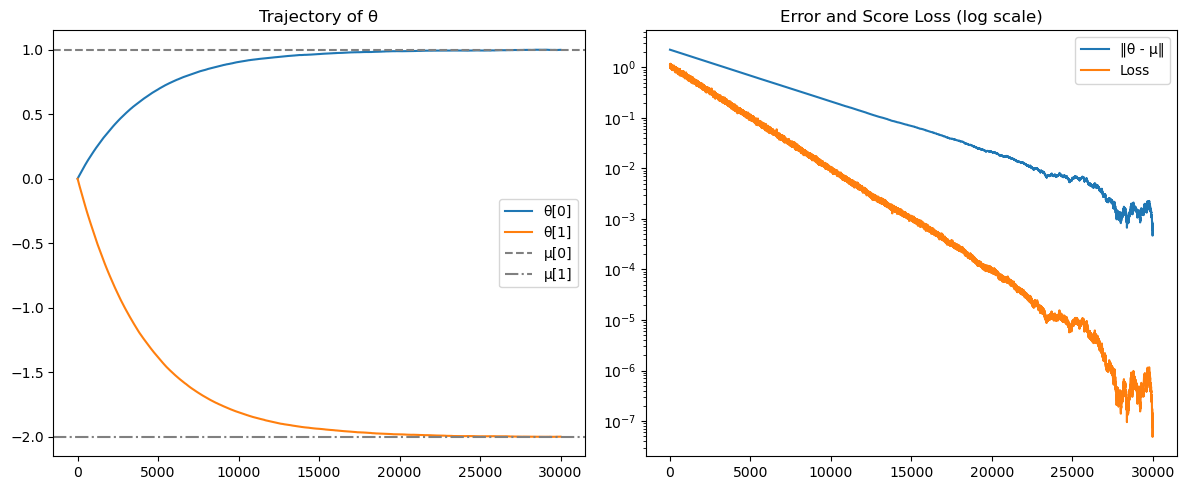

Saved: vectors_over_time.parquet and score_over_time.parquet


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dim = 2
mu_true = torch.tensor([1.0, -2.0], device=device)
beta = 1e8
initial_lr = 1e-3
total_steps = 30000
avg_window = 100

def simulate_xt(x0, t):
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    z = torch.randn_like(x0)
    xt = m_t[:, None] * x0 + sigma_t[:, None] * z
    return xt, z, m_t, sigma_t

def sgld_step(theta, step, batch, beta):
    tau, x0, z = batch
    m_t = torch.exp(-tau)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * tau))
    x_t = m_t[:, None] * x0 + sigma_t[:, None] * z

    s_val = - x_t + m_t[:, None] * theta
    grad_s = m_t[:, None]
    term = (z / sigma_t[:, None]) + s_val
    H = 2 * m_t * sigma_t**2
    grad = (H[:, None] * term * grad_s).mean(dim=0)

    lr = initial_lr
    noise = torch.randn_like(theta)
    theta_next = theta - lr * grad + torch.sqrt(torch.tensor(2 * lr / beta, device=theta.device)) * noise

    if step % 5000 == 0:
        print(f"[{step}] grad norm: {grad.norm().item():.6f} | theta: {theta.cpu().numpy()}")

    return theta_next

def loss_fn(theta, x0, tau, z):
    m_t = torch.exp(-tau)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * tau))
    xt = m_t[:, None] * x0 + sigma_t[:, None] * z
    score = m_t[:, None] * (xt - theta)
    target = m_t[:, None] * (xt - mu_true)
    return ((score - target) ** 2).mean().item()

def get_data_loader(mu, batch_size=128, dim=2):
    while True:
        yield torch.randn(batch_size, dim, device=device) + mu

theta = torch.zeros(dim, device=device)
theta_history = []
error_history = []
loss_history = []
data = get_data_loader(mu=mu_true, batch_size=128, dim=dim)


taus_all = []
m_t_all = []
x_t_all = []
theta_all = []
s_val_all = []


for step in tqdm(range(total_steps)):
    tau = torch.rand(128, device=device) * (1.0 - 1e-3) + 1e-3 
    x0 = next(data)
    _, z, _, _ = simulate_xt(x0, tau)
    batch = (tau, x0, z)

    theta = sgld_step(theta, step, batch, beta)


    with torch.no_grad():
        m_t = torch.exp(-tau)
        sigma_t = torch.sqrt(1 - torch.exp(-2 * tau))
        x_t = m_t[:, None] * x0 + sigma_t[:, None] * z
        s_val = -x_t + m_t[:, None] * theta

        taus_all.append(tau.detach().cpu())
        m_t_all.append(m_t.detach().cpu())
        x_t_all.append(x_t.detach().cpu())
        theta_all.append(theta.detach().cpu().expand_as(x_t).cpu())
        s_val_all.append(s_val.detach().cpu())


    err = torch.norm(theta - mu_true).item()
    loss = loss_fn(theta, x0, tau, z)

    theta_history.append(theta.detach().cpu().numpy())
    error_history.append(err)
    loss_history.append(loss)

    if step % 1000 == 0:
        print(f"Step {step:5d} | θ = {theta.cpu().numpy()} | error = {err:.4f} | loss = {loss:.4f}")

theta_np = np.array(theta_history)
theta_avg = np.mean(theta_np[-avg_window:], axis=0)

print(f"\nFinal θ estimate (avg over last {avg_window}): {theta_avg}")
print(f"True μ = {mu_true.cpu().numpy()}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(theta_np[:, 0], label='θ[0]')
plt.plot(theta_np[:, 1], label='θ[1]')
plt.axhline(mu_true[0].item(), color='grey', linestyle='--', label='μ[0]')
plt.axhline(mu_true[1].item(), color='grey', linestyle='-.', label='μ[1]')
plt.legend()
plt.title("Trajectory of θ")

plt.subplot(1, 2, 2)
plt.plot(error_history, label='‖θ - μ‖')
plt.plot(loss_history, label='Loss')
plt.yscale('log')
plt.legend()
plt.title("Error and Score Loss (log scale)")

plt.tight_layout()
plt.show()

taus_all = torch.cat(taus_all)
m_t_all = torch.cat(m_t_all)
x_t_all = torch.cat(x_t_all)
theta_all = torch.cat(theta_all)
s_val_all = torch.cat(s_val_all)

df_main = pd.DataFrame({
    "tau": taus_all.numpy(),
    "m_t": m_t_all.numpy(),
    "x[0]": x_t_all[:, 0].numpy(),
    "x[1]": x_t_all[:, 1].numpy(),
    "theta[0]": theta_all[:, 0].numpy(),
    "theta[1]": theta_all[:, 1].numpy(),
})

df_score = pd.DataFrame({
    "score[0]": s_val_all[:, 0].numpy(),
    "score[1]": s_val_all[:, 1].numpy(),
})

df_main.to_parquet("vectors_over_time.parquet")
df_score.to_parquet("score_over_time.parquet")

print("Saved: vectors_over_time.parquet and score_over_time.parquet")